In [6]:
# import libraries

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [7]:
# run the data_processing file to get the training and validation sets

%run ../data_processing.ipynb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16626 entries, 0 to 16625
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Administrative  16626 non-null  int64  
 1   Informational   16626 non-null  int64  
 2   ProductRelated  16626 non-null  int64  
 3   ExitRates       16626 non-null  float64
 4   PageValues      16626 non-null  float64
 5   SpecialDay      16626 non-null  float64
 6   Month           16626 non-null  int64  
 7   Region          16626 non-null  int64  
 8   TrafficType     16626 non-null  int64  
 9   VisitorType0    16626 non-null  float64
 10  VisitorType1    16626 non-null  float64
 11  Weekend         16626 non-null  int64  
 12  Revenue         16626 non-null  int64  
dtypes: float64(5), int64(8)
memory usage: 1.6 MB


In [8]:
# compile parameters (can be updated for different variations and test)
X_TRAIN = x_train
Y_TRAIN = y_train

X_VALID = x_valid
Y_VALID = y_valid

X_TEST = x_test
Y_TEST = y_test

VALIDATION = (x_valid, y_valid)

ACTIVATION_FUNCTION = 'relu'
ACTIVATION_FUNCTION_OUTPUT = 'softmax'
EPOCHS = 50
INPUT_DIM = 12
KERNEL_INITIALIZER = 'he_uniform'
LEARNING_RATE = 0.03
LOSS_FUNCTION = 'categorical_crossentropy'
METRICS = ['accuracy']
OPTIMIZER = keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
VERBOSE = 0

# list of batch sizes to test (can be updated to test different batch sizes)
batch_sizes = [16, 32, 64, 128, 256, 512]

# dataframe to hold the loss and accuracy for each batch size
df_result = pd.DataFrame(columns=['batch_size', 'training_loss',
                                  'training_accuracy', 'validation_loss',
                                  'validation_accuracy', 'test_loss',
                                  'test_accuracy', 'time'])

# clears the dataset to avoid redundancy
df_result = df_result.iloc[0:0]

In [9]:
# create a baseline classifier
def create_baseline():

    # init a sequential NN
    classifier = Sequential()

    # Define the model architecture
    
    # 1st layer - takes in input
    classifier.add(Dense(units=512, kernel_initializer=KERNEL_INITIALIZER,
                         activation=ACTIVATION_FUNCTION, input_dim=INPUT_DIM))
    # 2nd layer
    classifier.add(Dense(units=128, kernel_initializer=KERNEL_INITIALIZER,
                         activation=ACTIVATION_FUNCTION))
    # 3rd layer
    classifier.add(Dense(units=96, kernel_initializer=KERNEL_INITIALIZER,
                         activation=ACTIVATION_FUNCTION))
    # output layer
    classifier.add(Dense(units=2, kernel_initializer=KERNEL_INITIALIZER,
                         activation=ACTIVATION_FUNCTION_OUTPUT))

    return classifier

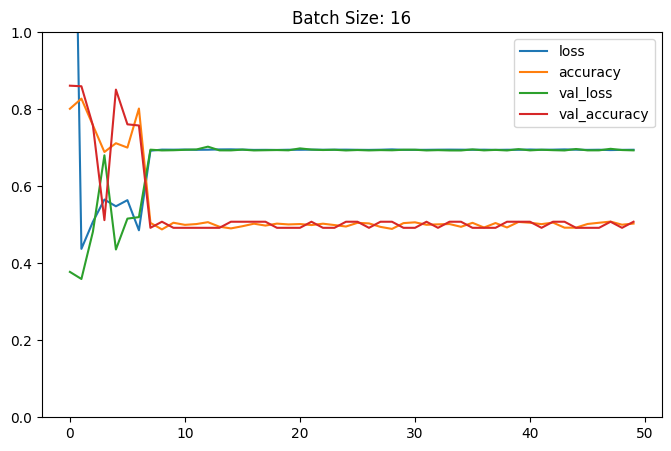

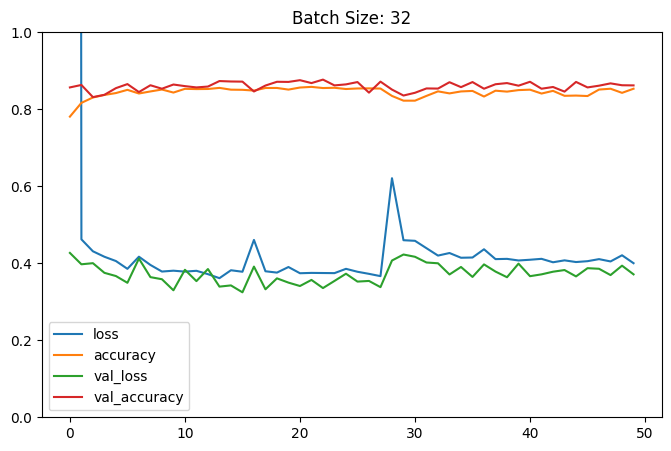

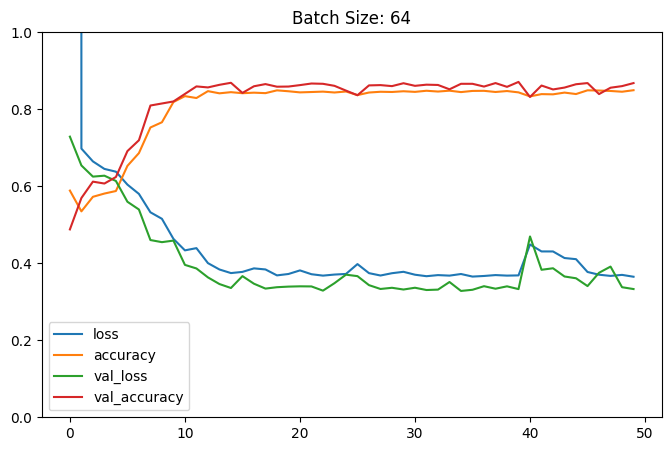

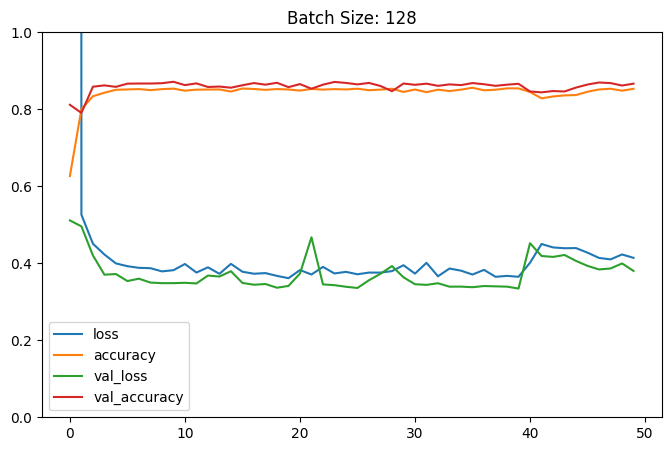

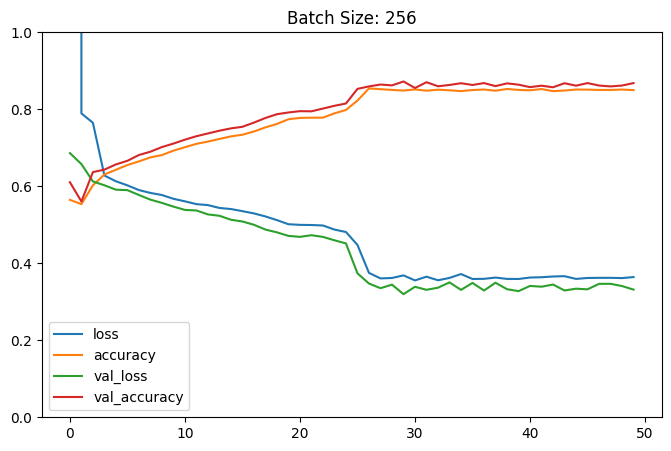

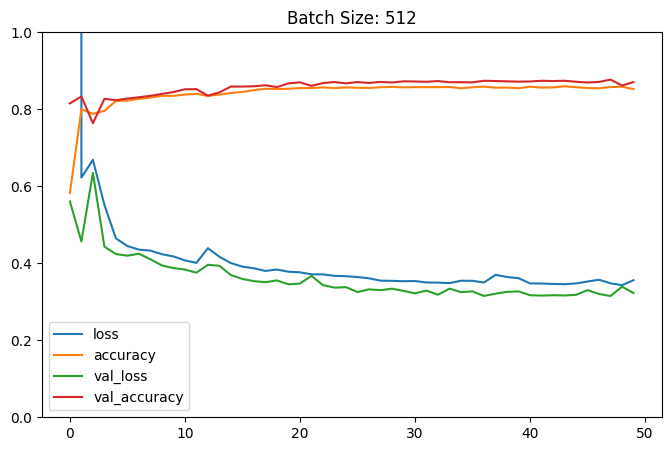

In [10]:
# loop through the batch_sizes list to test all the batch sizes
for BATCH_SIZE in batch_sizes:

    start_time = time.time()
    
    # create a baseline model
    model = create_baseline()

    # compile the model with values defined above
    model.compile(optimizer=OPTIMIZER,
                  loss=LOSS_FUNCTION, metrics=METRICS)
    
    # train the model
    history = model.fit(X_TRAIN, Y_TRAIN, validation_data=VALIDATION,
                            epochs=EPOCHS, batch_size=BATCH_SIZE,
                            verbose=VERBOSE)

    # plot
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid = True
    plt.ylim(0, 1)
    plt.title('Batch Size: ' + str(BATCH_SIZE))
    plt.savefig('figures/batch_size_'+str(BATCH_SIZE)+'.png')
    plt.show()

    # evaluation - loss and accuracy
    model_train_loss, model_train_accuracy = model.evaluate(X_TRAIN, Y_TRAIN,
                                                            verbose=VERBOSE)
    model_valid_loss, model_valid_accuracy = model.evaluate(X_VALID, Y_VALID,
                                                            verbose=VERBOSE)
    model_test_loss, model_test_accuracy = model.evaluate(X_TEST, Y_TEST,
                                                          verbose=VERBOSE)

    total_time = time.time() - start_time

    # add the evaluation results to the dataset
    df_result = pd.concat([pd.DataFrame([[BATCH_SIZE,
                                          model_train_loss,
                                          model_train_accuracy,
                                          model_valid_loss,
                                          model_valid_accuracy,
                                          model_test_loss,
                                          model_test_accuracy,
                                          total_time]],
                                          columns=df_result.columns),
                                          df_result],
                                          ignore_index=True)

In [11]:
# sort the dataframe by test accuracy
df_result = df_result.sort_values(by=['test_accuracy'], ascending=False)

# export the dataframe as a CSV file
df_result.to_csv('batch_size_result.csv', index=True)

# display the evaluation results dataframe
df_result

,batch_size,training_loss,training_accuracy,validation_loss,validation_accuracy,test_loss,test_accuracy,time
0,512,0.347306,0.860526,0.322706,0.870677,0.351369,0.854780,18.857788
1,256,0.358882,0.853853,0.331598,0.868045,0.366191,0.848166,22.427419
3,64,0.361072,0.854135,0.333052,0.868045,0.368369,0.845761,43.223298
2,128,0.399984,0.858647,0.380132,0.866541,0.426613,0.841852,25.618544
4,32,0.399515,0.849154,0.371233,0.862030,0.417825,0.840048,61.593589
5,16,0.694059,0.498120,0.693294,0.507895,0.693935,0.499699,145.156691


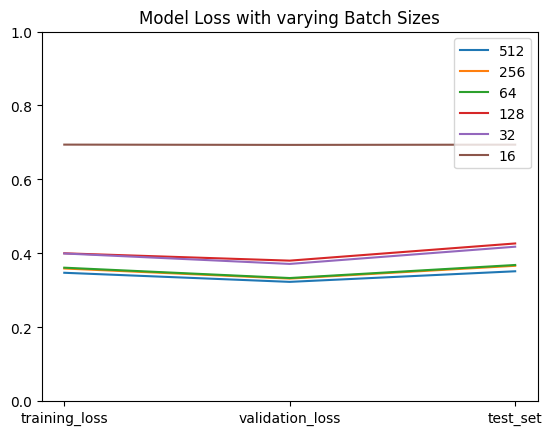

In [12]:
# visualize loss for training, validation and test sets

# x values
x = ['training_loss', 'validation_loss', 'test_set']

# training and validation loss for each batch size
for _idx in range(df_result.shape[0]):
    plt.plot(x, [df_result.iloc[_idx]['training_loss'],
                 df_result.iloc[_idx]['validation_loss'],
                 df_result.iloc[_idx]['test_loss']],
                 label=str(df_result.iloc[_idx]['batch_size']))

# plot
plt.grid = True
plt.ylim(0, 1)
plt.title('Model Loss with varying Batch Sizes')
plt.legend(loc='upper right')
plt.savefig('figures/loss.png')
plt.show()

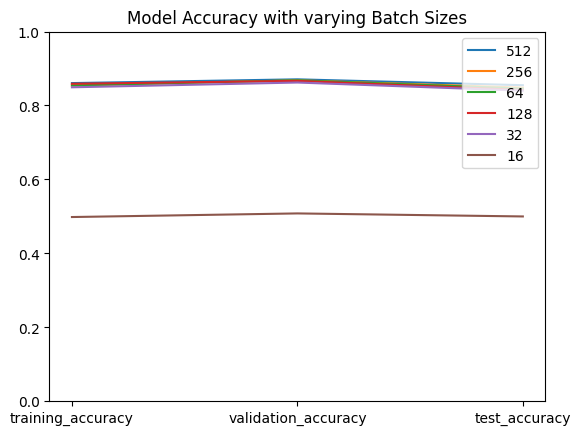

In [13]:
# visualize accuracy for training, validation and test sets

# x values
x = ['training_accuracy', 'validation_accuracy', 'test_accuracy']

# training and validation accuracy for each batch size
for _idx in range(df_result.shape[0]):
    plt.plot(x, [df_result.iloc[_idx]['training_accuracy'],
                 df_result.iloc[_idx]['validation_accuracy'],
                 df_result.iloc[_idx]['test_accuracy']],
                 label=str(df_result.iloc[_idx]['batch_size']))

# plot
plt.grid = True
plt.ylim(0, 1)
plt.title('Model Accuracy with varying Batch Sizes')
plt.legend(loc='upper right')
plt.savefig('figures/accuracy.png')
plt.show()